In [3]:
import torch
import torchvision
from torchvision.datasets import MNIST, CIFAR10
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn

In [2]:
dataset= MNIST('data/', 
                     train=True, 
                     transform= transforms.ToTensor())
len(dataset)

60000

In [3]:
test_dataset= MNIST('data/', 
                    train=False, 
                    transform= transforms.ToTensor())
len(test_dataset)

10000

In [6]:
dataset2= CIFAR10('data/', 
                    train=True, download=True,
                    transform= transforms.ToTensor())
len(dataset2)

Files already downloaded and verified


50000

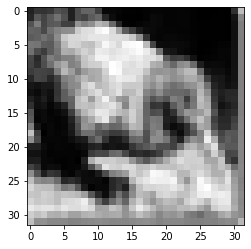

In [16]:
plt.imshow(dataset2[30003][0][0], cmap='gray')

In [5]:
def split_indices(n, val_split):
    n_split= int(n*val_split)
    indx= np.random.permutation(n)
    return indx[n_split:], indx[:n_split]


train_indx, val_indx= split_indices(len(dataset), 0.4)

train_loader= DataLoader(dataset,
                          batch_size=100,  
                          sampler= SubsetRandomSampler(train_indx)
                         )

val_loader= DataLoader(dataset,
                       batch_size=100,
                       sampler= SubsetRandomSampler(val_indx)
                       )

In [6]:
from torch.utils.data import random_split

train_dataset2, val_dataset2= random_split(dataset,[36000,24000])

train_dataset2= DataLoader(train_dataset2, 
                           batch_size=100, 
                           shuffle=True)

val_dataset2= DataLoader(val_dataset2, 
                         batch_size=100, 
                         shuffle=False)

In [7]:
in_size= 28*28
out_size= 10

class Mymodule(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear= nn.Linear(in_size, out_size)
    def forward(self, xb):
        xb= xb.reshape(-1, in_size)
        return self.linear(xb)
    def batch_step(self, batch):
        images, lables= batch
        out= self.forward(images)
        loss= nn.functional.cross_entropy(out, lables)
        acc= accuracy(out, lables)
        return {'loss': loss, 'acc': acc}


def train_step(model, train_loader, opt):
    results= []
    for batch in train_loader:
        result= model.batch_step(batch)
        loss= result['loss']
        loss.backward()
        opt.step()
        opt.zero_grad()
        results.append(result)
    return epoch_end(results)
   
def val_step(model, val_loader):
    results= [model.batch_step(batch) for batch in val_loader]
    return epoch_end(results)

def epoch_end(results):
    losses= [x['loss'] for x in results] 
    accs= [x['acc'] for x in results] 
    avg_loss= torch.stack(losses).mean()  
    avg_acc= torch.stack(accs).mean()
    return avg_loss, avg_acc

def print_epoch(avg_result, epoch, data_type):
    print("Epoch({}) {}_loss:{:.4f}, {}_acc:{:.4f}".format(epoch+1, data_type, avg_result[0].item(), data_type, avg_result[1].item()))
    

def accuracy(out, lables):
    pred=out.argmax(dim=1)
    acc= torch.tensor(torch.sum(pred==lables).item()/len(out))
    return acc

def fit(model, train_loader, val_loader, epochs, optimizer=torch.optim.SGD, lr= 1e-3):
    opt= optimizer(model.parameters(), lr)
    history_train= []
    history_val= []
    for epoch in range(epochs):
        # train step
        avg_result= train_step(model, train_loader, opt)
        print_epoch(avg_result, epoch, 'train')
        history_train.append(avg_result) 
        #val step
        avg_result= train_step(model, val_loader, opt)
        print_epoch(avg_result, epoch, 'val')   
        history_val.append(avg_result) 
    return history_train, history_val 


In [8]:
model= Mymodule()
optimizer= torch.optim.SGD
fit(model,train_loader, val_loader, 10, optimizer, 1e-3)

Epoch(1) train_loss:2.1259, train_acc:0.3656
Epoch(1) val_loss:1.8730, val_acc:0.6421
Epoch(2) train_loss:1.6798, train_acc:0.7173
Epoch(2) val_loss:1.5152, val_acc:0.7550
Epoch(3) train_loss:1.3949, train_acc:0.7690
Epoch(3) val_loss:1.2846, val_acc:0.7881
Epoch(4) train_loss:1.2070, train_acc:0.7922
Epoch(4) val_loss:1.1291, val_acc:0.8055
Epoch(5) train_loss:1.0767, train_acc:0.8076
Epoch(5) val_loss:1.0187, val_acc:0.8169
Epoch(6) train_loss:0.9818, train_acc:0.8192
Epoch(6) val_loss:0.9367, val_acc:0.8255
Epoch(7) train_loss:0.9099, train_acc:0.8270
Epoch(7) val_loss:0.8734, val_acc:0.8328
Epoch(8) train_loss:0.8534, train_acc:0.8333
Epoch(8) val_loss:0.8231, val_acc:0.8373
Epoch(9) train_loss:0.8079, train_acc:0.8376
Epoch(9) val_loss:0.7821, val_acc:0.8420
Epoch(10) train_loss:0.7703, train_acc:0.8414
Epoch(10) val_loss:0.7479, val_acc:0.8457


([(tensor(2.1259, grad_fn=<MeanBackward0>), tensor(0.3656)),
  (tensor(1.6798, grad_fn=<MeanBackward0>), tensor(0.7173)),
  (tensor(1.3949, grad_fn=<MeanBackward0>), tensor(0.7690)),
  (tensor(1.2070, grad_fn=<MeanBackward0>), tensor(0.7922)),
  (tensor(1.0767, grad_fn=<MeanBackward0>), tensor(0.8076)),
  (tensor(0.9818, grad_fn=<MeanBackward0>), tensor(0.8192)),
  (tensor(0.9099, grad_fn=<MeanBackward0>), tensor(0.8270)),
  (tensor(0.8534, grad_fn=<MeanBackward0>), tensor(0.8333)),
  (tensor(0.8079, grad_fn=<MeanBackward0>), tensor(0.8376)),
  (tensor(0.7703, grad_fn=<MeanBackward0>), tensor(0.8414))],
 [(tensor(1.8730, grad_fn=<MeanBackward0>), tensor(0.6421)),
  (tensor(1.5152, grad_fn=<MeanBackward0>), tensor(0.7550)),
  (tensor(1.2846, grad_fn=<MeanBackward0>), tensor(0.7881)),
  (tensor(1.1291, grad_fn=<MeanBackward0>), tensor(0.8055)),
  (tensor(1.0187, grad_fn=<MeanBackward0>), tensor(0.8169)),
  (tensor(0.9367, grad_fn=<MeanBackward0>), tensor(0.8255)),
  (tensor(0.8734, grad_